In [5]:
import sys
import os
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import keras_cv as keras_cv
#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')
#Create Instances Of Utils Helper
seed = 5000
labels = {0: 'Species1', 1: 'Species2', 2: 'Species3', 3: 'Species4', 4: 'Species5', 5: 'Species6', 6: 'Species7',
          7: 'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../", seed, create_dirs=True)  #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper = ModelHelper("../../", labels)  #take in input local models folder and lables
model_helper.create_seed(tf, seed);

#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 20000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=9634)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.1)


2.10.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248  

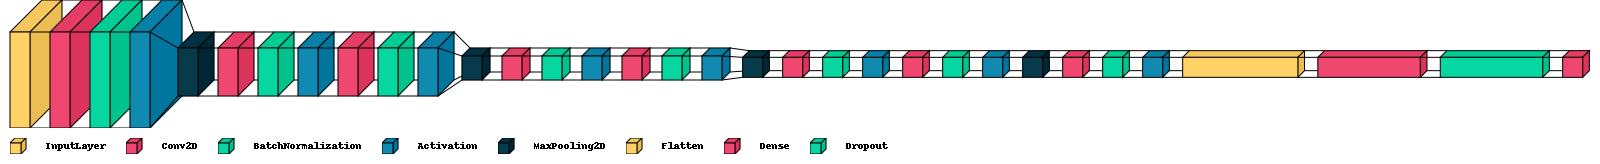

In [6]:
input_shape = X_train.shape[1:]  # 96*96*3
batch_size = 128
epochs = 50


def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    depth = 8
    start_n_f = 32
    last_layer = input_layer

    # last_layer = keras_cv.layers.GridMask(
    #     ratio_factor=(0, 0.5),
    #     rotation_factor=0.15,
    #     fill_mode="constant",
    #     fill_value=0.0,
    # )(last_layer)

    for i in range(depth):
        kernel_size = (3, 3) if i == 0 else (3, 3)
        conv = tfkl.Conv2D(
            filters=start_n_f,
            kernel_size=kernel_size,
            strides=(1, 1),
            padding='same',
            activation=None,
            kernel_initializer=tfk.initializers.HeUniform(seed)
        )(last_layer)
        batch = BatchNormalization()(conv)
        activation = tfkl.Activation('relu')(batch)
        last_layer = activation
        if i % 2 == 0:
            pool = tfkl.MaxPooling2D((2, 2), padding='same')(activation)
            last_layer = pool
            start_n_f *= (1 if i % 2 == 0 else 2)

    flattening_layer = tfkl.Flatten(name='Flatten')(last_layer)
    classifier_layer = tfkl.Dense(
        units=1024,
        name='Classifier',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=8,
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

2022-11-22 08:49:50.510526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 1.8726 - accuracy: 0.3745

2022-11-22 08:49:53.111038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 4s 88ms/step - loss: 1.8726 - accuracy: 0.3745 - val_loss: 3.7083 - val_accuracy: 0.1441


INFO:tensorflow:Assets written to: ../../local_saved_models/model_1/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model_1/assets


 8/12 [===================>..........] - ETA: 0s

2022-11-22 08:49:59.153122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 13ms/step
Accuracy: 0.1441
Precision: 0.0181
Recall: 0.125
F1: 0.0316


/Users/forna/Documents/1.Politecnico/AN2DL/challenges/AN2DL-Challenges/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


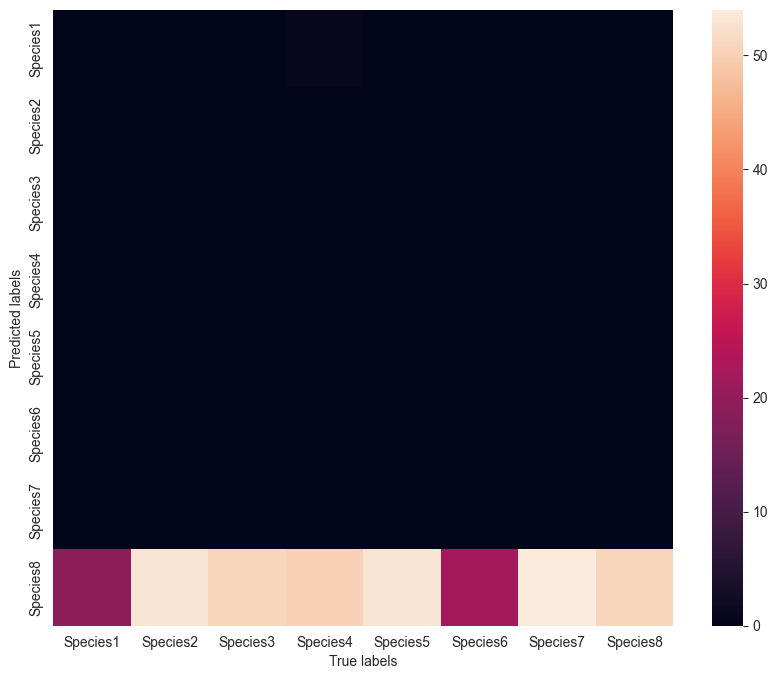

In [7]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

model_helper.save_model(model, 'model_1')
model = model_helper.load_model('model_1')
model_helper.show_confusion_matrix(X_test, Y_test, model=model)

2022-11-22 08:50:00.868383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 1.2460 - accuracy: 0.5409

2022-11-22 08:50:03.432152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 4s 84ms/step - loss: 1.2460 - accuracy: 0.5409 - val_loss: 2.7055 - val_accuracy: 0.1638


INFO:tensorflow:Assets written to: ../../local_saved_models/model_2/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model_2/assets


12/12 [==============================] - 0s 10ms/step


2022-11-22 08:50:09.332033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/forna/Documents/1.Politecnico/AN2DL/challenges/AN2DL-Challenges/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.1582
Precision: 0.0696
Recall: 0.171
F1: 0.0942


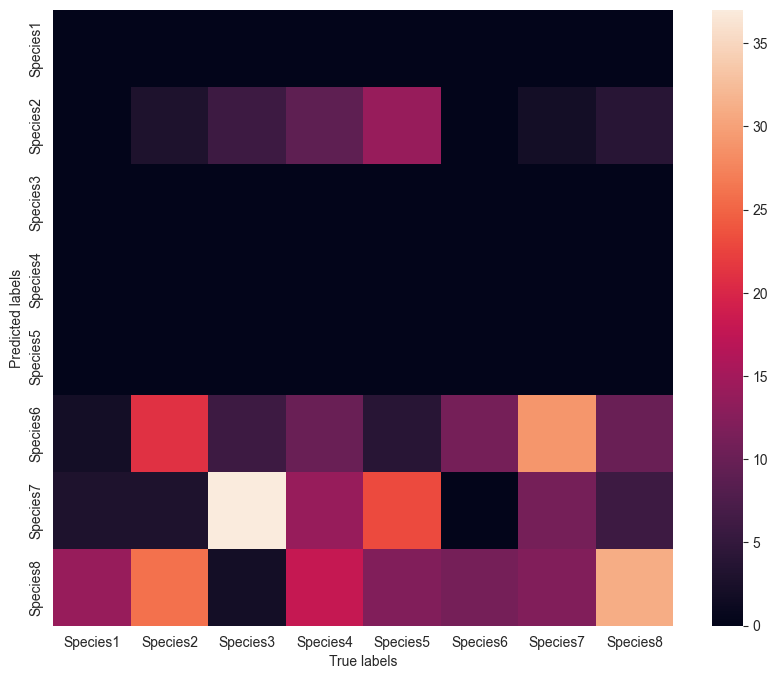

In [8]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 20000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=453)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.1)

# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

model_helper.save_model(model, 'model_2')
model = model_helper.load_model('model_2')
model_helper.show_confusion_matrix(X_test, Y_test, model=model)

2022-11-22 08:50:10.834393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 0.9062 - accuracy: 0.6834

2022-11-22 08:50:13.504071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 4s 85ms/step - loss: 0.9062 - accuracy: 0.6834 - val_loss: 3.0739 - val_accuracy: 0.2232


INFO:tensorflow:Assets written to: ../../local_saved_models/model_3/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model_3/assets


 8/12 [===================>..........] - ETA: 0s

2022-11-22 08:50:19.486464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 13ms/step
Accuracy: 0.1921
Precision: 0.0955
Recall: 0.1601
F1: 0.0826


/Users/forna/Documents/1.Politecnico/AN2DL/challenges/AN2DL-Challenges/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


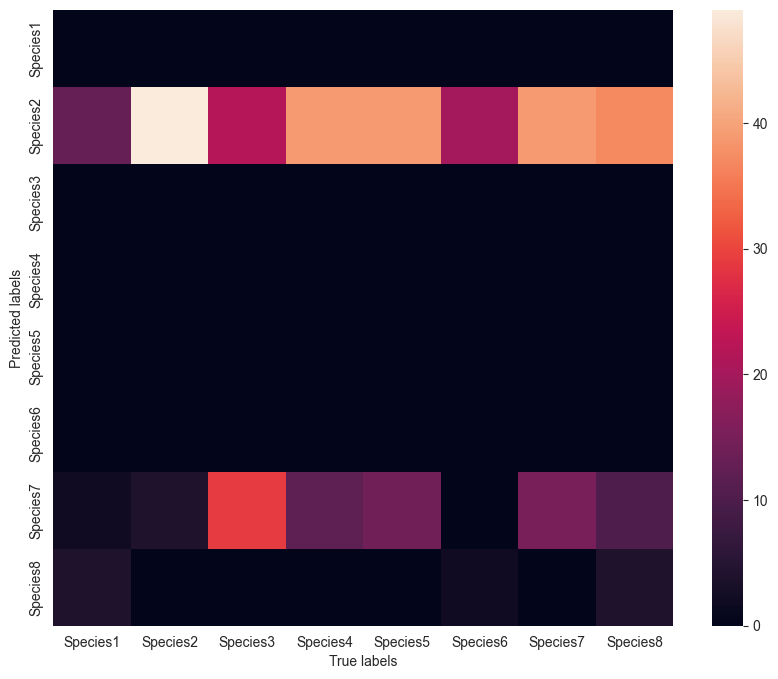

In [9]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 20000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=123)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.1)

# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

model_helper.save_model(model, 'model_3')
model = model_helper.load_model('model_3')
model_helper.show_confusion_matrix(X_test, Y_test, model=model)

2022-11-22 08:50:20.981640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.7483

2022-11-22 08:50:23.585646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 4s 84ms/step - loss: 0.6950 - accuracy: 0.7483 - val_loss: 4.2262 - val_accuracy: 0.1328


INFO:tensorflow:Assets written to: ../../local_saved_models/model_4/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model_4/assets


 7/12 [================>.............] - ETA: 0s

2022-11-22 08:50:29.551366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 12ms/step
Accuracy: 0.1299
Precision: 0.0866
Recall: 0.179
F1: 0.0877


/Users/forna/Documents/1.Politecnico/AN2DL/challenges/AN2DL-Challenges/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


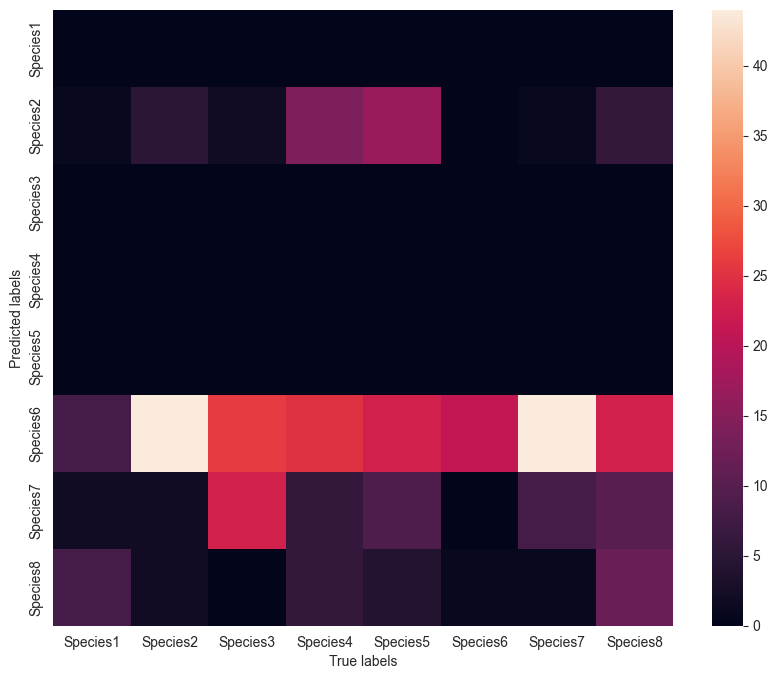

In [10]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 20000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=5678)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.1)

# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

model_helper.save_model(model, 'model_4')
model = model_helper.load_model('model_4')
model_helper.show_confusion_matrix(X_test, Y_test, model=model)